In [2]:
import numpy as np
import pandas as pd
import matplotlib.pylab as plt
import calculate_cleavage_rate_sd as clv
import preprocessing
import read_model_ID_sd as model
import sys
sys.path.append('../../code_general/')
sys.path.append('../')
import calculate_cleavage_rate as clv2
import read_model_ID as model2
reload(clv)
reload(clv2)
reload(preprocessing)
reload(model)
from matplotlib.lines import Line2D
%matplotlib inline

## Load Data

In [3]:
path = '../../data_nucleaseq_Finkelsteinlab/targetE_Stijn/'
xdata_smm,ydata_smm,yerr_smm = preprocessing.prepare_multiprocessing_seq_dep('WT_cleavage_rate_and_y0_Canonical_OT-r_1-1_target.csv',path)
xdata_all,ydata_all,yerr_all = preprocessing.prepare_multiprocessing_seq_dep('WT_cleavage_rate_and_y0_Canonical_OT-r_0-2_target.csv',path)
xdata_smm_wa,ydata_smm_wa,yerr_smm_wa = preprocessing.prepare_multiprocessing_seq_dep_wa('WT_cleavage_rate_and_y0_Canonical_OT-r_1-1_target.csv',path)
xdata_all_wa,ydata_all_wa,yerr_all_wa = preprocessing.prepare_multiprocessing_seq_dep_wa('WT_cleavage_rate_and_y0_Canonical_OT-r_0-2_target.csv',path)


path = '../../data_ABA_Finkelsteinlab/champ-cas9-cas12a-data_Stijn/'
file1 = 'TargetE-dCas9_AbsoluteABA_Canonical_OT-r_1-1_target.csv'
file2 = 'TargetE-dCas9_AbsoluteABA_Canonical_OT-r_0-2_target.csv'
xdata_smm_aba,ydata_smm_aba,yerr_smm_aba = preprocessing.prepare_multiprocessing_seq_dep_aba(file1,path)
xdata_all_aba,ydata_all_aba,yerr_all_aba = preprocessing.prepare_multiprocessing_seq_dep_aba(file2,path)
xdata_smm_wa_aba,ydata_smm_wa_aba,yerr_smm_wa_aba = preprocessing.prepare_multiprocessing_seq_dep_wa_aba(file1,path)
xdata_all_wa_aba,ydata_all_wa_aba,yerr_all_wa_aba = preprocessing.prepare_multiprocessing_seq_dep_wa_aba(file2,path)

model_ID = 'Clv_Saturated_general_energies_v2+general_energies_no_kPR'; parnum = '44'
filename = 'fit_18_7_2019_sim_17.txt'
path = '../../fits_Stijn/18_7_2019/'
data = pd.read_table(path+filename,index_col=False)
chi = data.loc[:,'Potential']
T = data.loc[:,'Temperature']
final_par = data.loc[np.argmin(chi),'Parameter 1':'Parameter '+parnum]
final_par_np = np.array(final_par.values)

model_ID_clv,model_ID_on,parameters_clv,parameters_on = model2.combined_model(final_par_np,model_ID)
energiesWT,ratesWT = model2.unpack_parameters(parameters_on,model_ID_on,20)

## Importing Fit Results

best fit: ../../fits_Stijn/26_8_2019/fit_26_8_2019_sim_2.txt
all chi_squared: [3221.7813651199999, 3197.4978176599998, 3345.92967929, 3247.08053251, 3211.1976496699999]
5


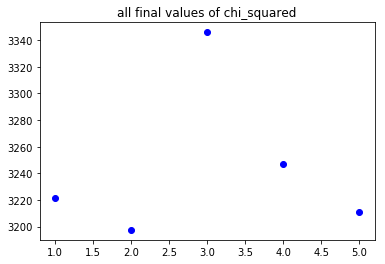

In [4]:
chi_squared = []
energies = []
simset = []
final_par = []
ei = False
before = True
after = False
direct = False

#-----please pick one of these models-----
if False: #Local model
    model_id = 'seq_dep_finetuning_direct_pairs'; parnum = '12'; direct = True
    file = '../../fits_Stijn/22_8_2019/fit_22_8_2019_sim_'
    fit_nums = range(1,6)
    
if False: #Nearest neighbour model
    model_id = 'seq_dep_finetuning_nearest_neighbour_both'; parnum = '45';before = True; after = True
    file = '../../fits_Stijn/26_8_2019/fit_26_8_2019_sim_'
    fit_nums = range(6,11)
    
if False: #One neighbour before, not in thesis
    model_id = 'seq_dep_finetuning_nearest_neighbour'; parnum = '33'
    file = '../../fits_Stijn/22_8_2019/fit_22_8_2019_sim_'
    fit_nums = range(6,11)

if True: #One neighbour after, not in thesis
    model_id = 'seq_dep_finetuning_nearest_neighbour_after'; parnum = '30';before = False; after = True
    file = '../../fits_Stijn/26_8_2019/fit_26_8_2019_sim_'
    fit_nums = range(1,6)

if ei:
    epsilon_i = []

#---------- collect simulations ---------------
for sim in fit_nums:
    sa = pd.read_csv(file +str(sim)+'.txt', delimiter='\t', index_col=False)
    filename = file +str(sim) +'.txt'   
    chi_squared.append(sa.Potential.iloc[np.argmin(sa.Potential)])
    simset.append(filename)
    final_par_temp = sa.loc[np.argmin(sa.Potential),'Parameter 1':'Parameter '+parnum]
    final_par_temp = final_par_temp.values
    #final_par_temp[16] += 1.3
    
    epsilon_si,_,epsilon_i_sd = model.unpack_parameters(final_par_temp,model_id,20)
    
    if ei:
        epsilon_i.append(epsilon_si[-20:])

    energies.append(epsilon_i_sd)
    final_par.append(final_par_temp)
    
best_fit = simset[np.argmin(chi_squared)]
print 'best fit: ' + best_fit
print 'all chi_squared: ' + str(chi_squared)

chi_squared = np.array(chi_squared)
indices_low_chi = np.where(chi_squared<800000)
final_par_low_chi = np.array(final_par)[indices_low_chi[0]]
energies_low_chi = np.array(energies)[indices_low_chi[0]]
low_chi = chi_squared[indices_low_chi[0]]
plt.plot(range(1,len(chi_squared)+1),chi_squared,'bo')
plt.title('all final values of chi_squared')

median = np.zeros(len(final_par_low_chi[0]))
median_energies = np.zeros(len(energies_low_chi[0]))


for i in range(len(final_par_low_chi[0])):
    median_temp = list()
    for j in range(len(final_par_low_chi)):
        median_temp.append(final_par_low_chi[j][i])
    median[i] = np.median(np.array(median_temp))
    
for i in range(len(energies_low_chi[0])):
    median_temp = list()
    for j in range(len(energies_low_chi)):
        median_temp.append(energies_low_chi[j][i])
    median_energies[i] = np.median(np.array(median_temp))

if ei:
    epsilon_i_low_chi = np.array(epsilon_i)[indices_low_chi[0]]
    median_epsilon_i = np.zeros(len(epsilon_i_low_chi[0]))
    for i in range(len(epsilon_i_low_chi[0])):
        median_temp = list()
        for j in range(len(epsilon_i_low_chi)):
            median_temp.append(epsilon_i_low_chi[j][i])
        median_epsilon_i[i] = np.median(np.array(median_temp))
    
print len(final_par_low_chi)

## Sequence dependent penalties

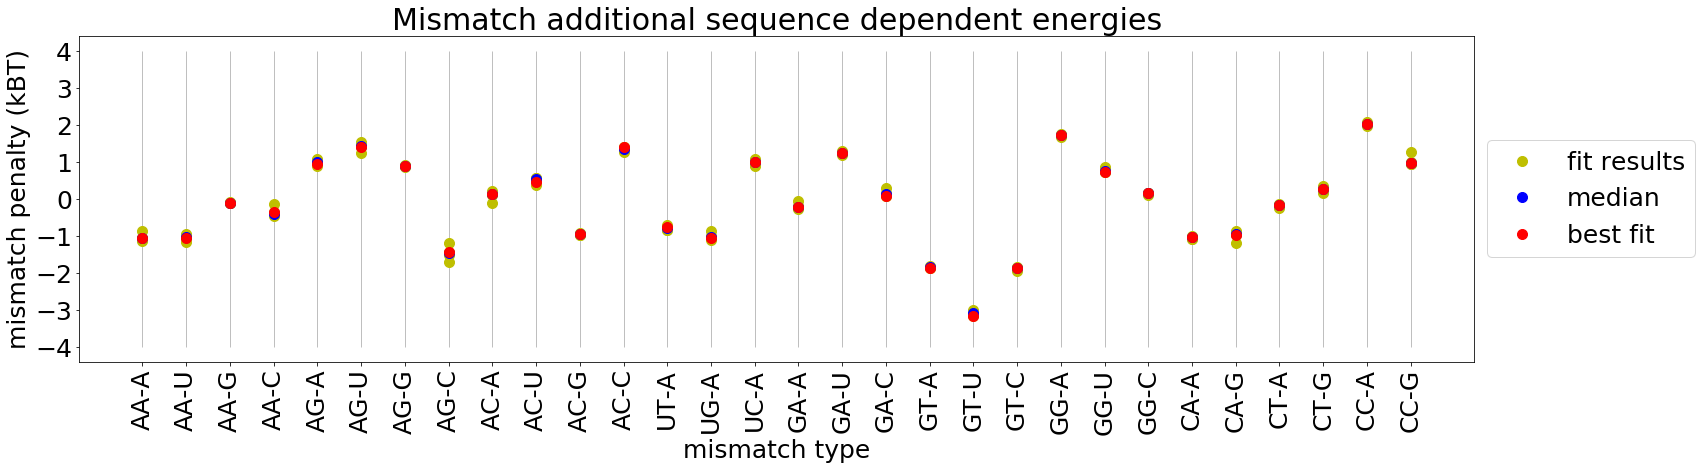

In [5]:
if before and not after:
    if direct:
        types = ['AA','AG','AC','UT','UG','UC','GA','GU','GG','CA','CU','CC']
        
        plt.figure(figsize=[15,6])
        for i in range(len(energies_low_chi)):
            plot1, = plt.plot([1,2,3,5,6,7,9,10,11,13,14,15],energies_low_chi[i][[0,4,8,12,14,16,18,20,22,24,27,30]],'yo',label='fit results',markersize=10.)

        plot2, = plt.plot([1,2,3,5,6,7,9,10,11,13,14,15],median_energies[[0,4,8,12,14,16,18,20,22,24,27,30]],'bo',label='median',markersize=10.)
        plot3, = plt.plot([1,2,3,5,6,7,9,10,11,13,14,15],energies[np.argmin(chi_squared)][[0,4,8,12,14,16,18,20,22,24,27,30]],'ro',label='best fit',markersize=10.)
        plt.legend(handles=[plot1,plot2,plot3],loc='center left', bbox_to_anchor=(1, 0.5),fontsize=25)
        plt.xlabel('mismatch type',fontsize=25)
        plt.ylabel('mismatch penalty (kBT)',fontsize=25)
        plt.title('Mismatch additional sequence dependent energies',fontsize=30)

        if model_id[-4] == 't':
            plt.vlines([1,2,3,5,6,7,9,10,11,13,14,15],0,12,color='grey',linewidth=0.5);
        else:
            plt.vlines([1,2,3,5,6,7,9,10,11,13,14,15],-4.,4.,color='grey',linewidth=0.5);

        plt.xticks([1,2,3,5,6,7,9,10,11,13,14,15],types,fontsize=25,rotation='vertical');
        plt.yticks(fontsize=25)

        if ei:
            plt.figure()
            for i in range(len(epsilon_i_low_chi)):
                plot1, = plt.plot(range(1,21),epsilon_i_low_chi[i],'yo',label='fit results')

            plot4, = plt.plot(range(1,21),energiesWT[21:41],'go',label='sequence independent fit')

            plot2, = plt.plot(range(1,21),median_epsilon_i,'bo',label='median')
            plot3, = plt.plot(range(1,21),epsilon_i[np.argmin(chi_squared)],'ro',label='best fit')


            plt.legend(handles=[plot1,plot2,plot3,plot4],loc='center left', bbox_to_anchor=(1, 0.5),fontsize=15)
            plt.xlabel('position',fontsize=15)
            plt.ylabel('Penalty (kBT)',fontsize=15)
            plt.title('Mismatch Penalties',fontsize=15)
            plt.vlines(range(1,21),0,10,color='grey',linewidth=0.5);
            plt.xticks(range(1,21),range(1,21),fontsize=15,rotation='vertical');
            plt.yticks(fontsize=15);
    else:
        types = ['A-AA','U-AA','G-AA','C-AA','A-AG','U-AG','G-AG','C-AG','A-AC','U-AC','G-AC','C-AC','A-UT','G-UT','A-UG','G-UG',
                 'A-UC','G-UC','A-GA','C-GA','A-GT','C-GT','A-GG','C-GG','A-CA','G-CA','P-CA','A-CT','G-CT','P-CT','A-CC','G-CC','P-CC']

        plt.figure(figsize=[25,6])
        for i in range(len(energies_low_chi)):
            plot1, = plt.plot([1,2,3,4, 6,7,8,9, 11,12,13,14, 17,18, 20,21, 23,24, 27,28, 30,31, 33,34, 37,38,39, 41,42,43, 45,46,47],energies_low_chi[i],'yo',label='fit results',markersize=10.)

        plot2, = plt.plot([1,2,3,4, 6,7,8,9, 11,12,13,14, 17,18, 20,21, 23,24, 27,28, 30,31, 33,34, 37,38,39, 41,42,43, 45,46,47],median_energies,'bo',label='median',markersize=10.)
        plot3, = plt.plot([1,2,3,4, 6,7,8,9, 11,12,13,14, 17,18, 20,21, 23,24, 27,28, 30,31, 33,34, 37,38,39, 41,42,43, 45,46,47],energies[np.argmin(chi_squared)],'ro',label='best fit',markersize=10.)
        plt.legend(handles=[plot1,plot2,plot3],loc='center left', bbox_to_anchor=(1, 0.5),fontsize=25)
        plt.xlabel('mismatch type',fontsize=25)
        plt.ylabel('mismatch penalty (kBT)',fontsize=25)
        plt.title('Mismatch additional sequence dependent energies',fontsize=30)

        if model_id[-4] == 't':
            plt.vlines([1,2,3,4, 6,7,8,9, 11,12,13,14, 17,18, 20,21, 23,24, 27,28, 30,31, 33,34, 37,38,39, 41,42,43, 45,46,47],0,12,color='grey',linewidth=0.5);
        else:
            plt.vlines([1,2,3,4, 6,7,8,9, 11,12,13,14, 17,18, 20,21, 23,24, 27,28, 30,31, 33,34, 37,38,39, 41,42,43, 45,46,47],-4.,4.,color='grey',linewidth=0.5);

        plt.xticks([1,2,3,4, 6,7,8,9, 11,12,13,14, 17,18, 20,21, 23,24, 27,28, 30,31, 33,34, 37,38,39, 41,42,43, 45,46,47],types,fontsize=25,rotation='vertical');
        plt.yticks(fontsize=25)

        if ei:
            plt.figure()
            for i in range(len(epsilon_i_low_chi)):
                plot1, = plt.plot(range(1,21),epsilon_i_low_chi[i],'yo',label='fit results')

            plot4, = plt.plot(range(1,21),energiesWT[21:41],'go',label='sequence independent fit')

            plot2, = plt.plot(range(1,21),median_epsilon_i,'bo',label='median')
            plot3, = plt.plot(range(1,21),epsilon_i[np.argmin(chi_squared)],'ro',label='best fit')


            plt.legend(handles=[plot1,plot2,plot3,plot4],loc='center left', bbox_to_anchor=(1, 0.5),fontsize=15)
            plt.xlabel('position',fontsize=15)
            plt.ylabel('Penalty (kBT)',fontsize=15)
            plt.title('Mismatch Penalties',fontsize=15)
            plt.vlines(range(1,21),0,10,color='grey',linewidth=0.5);
            plt.xticks(range(1,21),range(1,21),fontsize=15,rotation='vertical');
            plt.yticks(fontsize=15);
if after and not before:
    types = ['AA-A','AA-U','AA-G','AA-C','AG-A','AG-U','AG-G','AG-C','AC-A','AC-U','AC-G','AC-C','UT-A','UG-A',
             'UC-A','GA-A','GA-U','GA-C','GT-A','GT-U','GT-C','GG-A','GG-U','GG-C','CA-A','CA-G','CT-A','CT-G','CC-A','CC-G']

    plt.figure(figsize=[25,6])
    for i in range(len(energies_low_chi)):
        plot1, = plt.plot(range(1,31),energies_low_chi[i],'yo',label='fit results',markersize=10.)

    plot2, = plt.plot(range(1,31),median_energies,'bo',label='median',markersize=10.)
    plot3, = plt.plot(range(1,31),energies[np.argmin(chi_squared)],'ro',label='best fit',markersize=10.)
    plt.legend(handles=[plot1,plot2,plot3],loc='center left', bbox_to_anchor=(1, 0.5),fontsize=25)
    plt.xlabel('mismatch type',fontsize=25)
    plt.ylabel('mismatch penalty (kBT)',fontsize=25)
    plt.title('Mismatch additional sequence dependent energies',fontsize=30)

    if model_id[-4] == 't':
        plt.vlines(range(1,31),0,12,color='grey',linewidth=0.5);
    else:
        plt.vlines(range(1,31),-4.,4.,color='grey',linewidth=0.5);

    plt.xticks(range(1,31),types,fontsize=25,rotation='vertical');
    plt.yticks(fontsize=25)

    if ei:
        plt.figure()
        for i in range(len(epsilon_i_low_chi)):
            plot1, = plt.plot(range(1,21),epsilon_i_low_chi[i],'yo',label='fit results')

        plot4, = plt.plot(range(1,21),energiesWT[21:41],'go',label='sequence independent fit')

        plot2, = plt.plot(range(1,21),median_epsilon_i,'bo',label='median')
        plot3, = plt.plot(range(1,21),epsilon_i[np.argmin(chi_squared)],'ro',label='best fit')


        plt.legend(handles=[plot1,plot2,plot3,plot4],loc='center left', bbox_to_anchor=(1, 0.5),fontsize=15)
        plt.xlabel('position',fontsize=15)
        plt.ylabel('Penalty (kBT)',fontsize=15)
        plt.title('Mismatch Penalties',fontsize=15)
        plt.vlines(range(1,21),0,10,color='grey',linewidth=0.5);
        plt.xticks(range(1,21),range(1,21),fontsize=15,rotation='vertical');
        plt.yticks(fontsize=15);
if before and after:
    types = ['A-AA-A','A-AA-U','U-AA-G','U-AA-C','G-AA-A','G-AA-G','C-AA-G','A-AG-A','A-AG-U','U-AG-G','U-AG-C','G-AG-A',
            'G-AG-G','C-AG-G','A-AC-A','A-AC-U','U-AC-G','U-AC-C','G-AC-A','G-AC-G','C-AC-G','A-UT-A','G-UT-A','A-UG-A','G-UG-A',
            'A-UC-A','G-UC-A','A-GA-A','A-GA-U','C-GA-C','A-GT-A','A-GT-U','C-GT-C','A-GG-A','A-GG-U','C-GG-C','A-CA-G',
            'G-CA-A','P-CA-G','A-CT-G','G-CT-A','P-CT-G','A-CC-G','G-CC-A','P-CC-G']
    plt.figure(figsize=[25,6])
    for i in range(len(energies_low_chi)):
        plot1, = plt.plot([1,2,3,4,5,6,7, 9,10,11,12,13,14,15, 17,18,19,20,21,22,23, 26,27, 29,30, 32,33, 36,37,38, 40,41,42, 44,45,46, 49,50,51, 53,54,55, 57,58,59],energies_low_chi[i],'yo',label='fit results',markersize=10.)

    plot2, = plt.plot([1,2,3,4,5,6,7, 9,10,11,12,13,14,15, 17,18,19,20,21,22,23, 26,27, 29,30, 32,33, 36,37,38, 40,41,42, 44,45,46, 49,50,51, 53,54,55, 57,58,59],median_energies,'bo',label='median',markersize=10.)
    plot3, = plt.plot([1,2,3,4,5,6,7, 9,10,11,12,13,14,15, 17,18,19,20,21,22,23, 26,27, 29,30, 32,33, 36,37,38, 40,41,42, 44,45,46, 49,50,51, 53,54,55, 57,58,59],energies[np.argmin(chi_squared)],'ro',label='best fit',markersize=10.)
    plt.legend(handles=[plot1,plot2,plot3],loc='center left', bbox_to_anchor=(1, 0.5),fontsize=25)
    plt.xlabel('mismatch type',fontsize=25)
    plt.ylabel('mismatch penalty (kBT)',fontsize=25)
    plt.title('Mismatch additional sequence dependent energies',fontsize=30)

    if model_id[-4] == 't':
        plt.vlines([1,2,3,4,5,6,7, 9,10,11,12,13,14,15, 17,18,19,20,21,22,23, 26,27, 29,30, 32,33, 36,37,38, 40,41,42, 44,45,46, 49,50,51, 53,54,55, 57,58,59],0,12,color='grey',linewidth=0.5);
    else:
        plt.vlines([1,2,3,4,5,6,7, 9,10,11,12,13,14,15, 17,18,19,20,21,22,23, 26,27, 29,30, 32,33, 36,37,38, 40,41,42, 44,45,46, 49,50,51, 53,54,55, 57,58,59],-4.,4.,color='grey',linewidth=0.5);

    plt.xticks([1,2,3,4,5,6,7, 9,10,11,12,13,14,15, 17,18,19,20,21,22,23, 26,27, 29,30, 32,33, 36,37,38, 40,41,42, 44,45,46, 49,50,51, 53,54,55, 57,58,59],types,fontsize=25,rotation='vertical');
    plt.yticks(fontsize=25)

    if ei:
        plt.figure()
        for i in range(len(epsilon_i_low_chi)):
            plot1, = plt.plot(range(1,21),epsilon_i_low_chi[i],'yo',label='fit results')

        plot4, = plt.plot(range(1,21),energiesWT[21:41],'go',label='sequence independent fit')

        plot2, = plt.plot(range(1,21),median_epsilon_i,'bo',label='median')
        plot3, = plt.plot(range(1,21),epsilon_i[np.argmin(chi_squared)],'ro',label='best fit')


        plt.legend(handles=[plot1,plot2,plot3,plot4],loc='center left', bbox_to_anchor=(1, 0.5),fontsize=15)
        plt.xlabel('position',fontsize=15)
        plt.ylabel('Penalty (kBT)',fontsize=15)
        plt.title('Mismatch Penalties',fontsize=15)
        plt.vlines(range(1,21),0,10,color='grey',linewidth=0.5);
        plt.xticks(range(1,21),range(1,21),fontsize=15,rotation='vertical');
        plt.yticks(fontsize=15);

## Best Fit:

Upper correlation plots are of sequence indep model


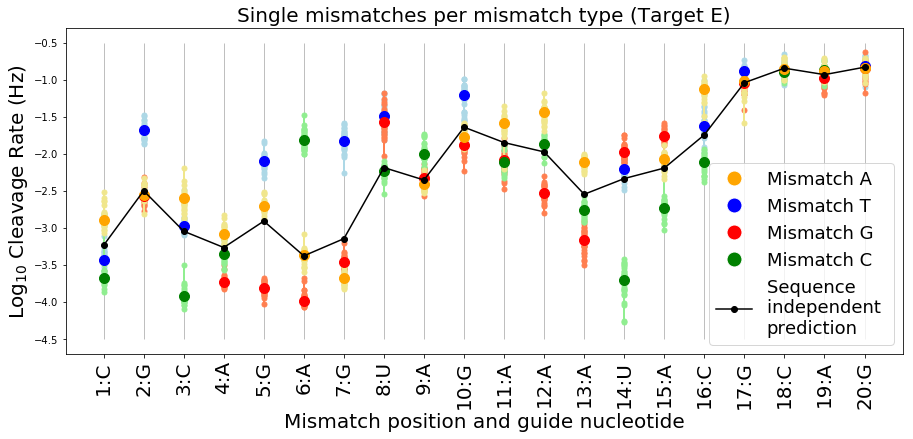

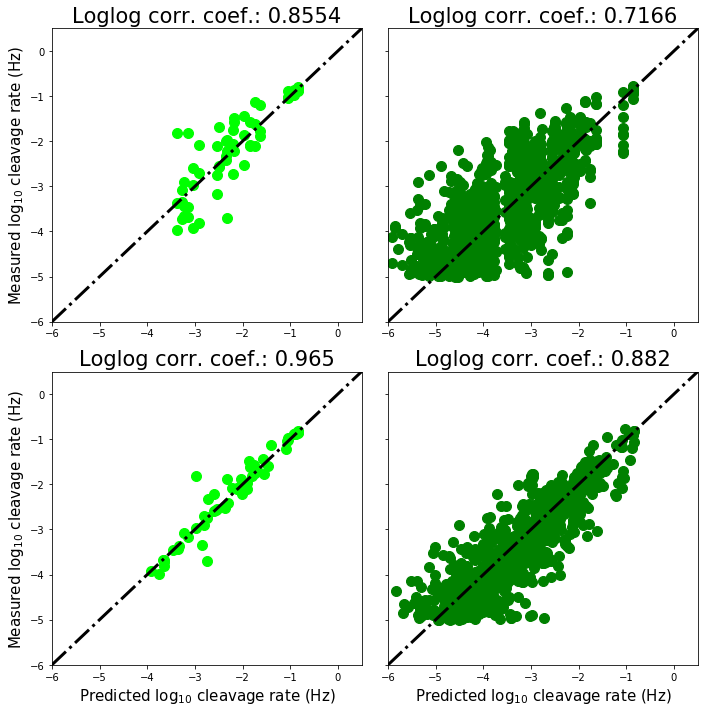

In [6]:
parameters = final_par[np.argmin(chi_squared)]
#parameters = final_par[3]
plt.figure(figsize=[15,6])

guide_sequenceE = 'CGCAGAGUAGAAAUACGCAG'
label = []
for i in range(20):
    label.append(str(i+1) + ':' + guide_sequenceE[i])

for j in range(len(xdata_smm)):
    if len(xdata_smm[j][2])>0:
        if xdata_smm[j][0][xdata_smm[j][2][0]-1]=='A':
            color = 'lightblue'
            plt.plot(xdata_smm_wa[j][2][0]*np.ones(len(ydata_smm[j])),ydata_smm[j],color=color,marker='o',markersize=5.)
        elif xdata_smm[j][0][xdata_smm[j][2][0]-1]=='T':
            color = 'khaki'
            plt.plot(xdata_smm_wa[j][2][0]*np.ones(len(ydata_smm[j])),ydata_smm[j],color=color,marker='o',markersize=5.)
        elif xdata_smm[j][0][xdata_smm[j][2][0]-1]=='C':
            color = 'coral'
            plt.plot(xdata_smm_wa[j][2][0]*np.ones(len(ydata_smm[j])),ydata_smm[j],color=color,marker='o',markersize=5.)
        elif xdata_smm[j][0][xdata_smm[j][2][0]-1]=='G':
            color = 'lightgreen'
            plt.plot(xdata_smm_wa[j][2][0]*np.ones(len(ydata_smm[j])),ydata_smm[j],color=color,marker='o',markersize=5.)

for j in range(len(xdata_smm_wa)):
    if len(xdata_smm_wa[j][2])>0:
        if xdata_smm_wa[j][0][xdata_smm_wa[j][2][0]-1]=='A':
            color = 'blue'
            #clv_temp = np.log10(clv.calc_clv_rate_fast(parameters,model_id,xdata_smm_wa[j],before=before,after=after))
            #plt.plot(xdata_smm_wa[j][2][0],clv_temp,color=color,marker='o',markersize=10.)
            plt.plot(xdata_smm_wa[j][2][0],ydata_smm_wa[j][0],color=color,marker='o',markersize=10.)
        elif xdata_smm_wa[j][0][xdata_smm_wa[j][2][0]-1]=='T':
            color = 'orange'
            #clv_temp = np.log10(clv.calc_clv_rate_fast(parameters,model_id,xdata_smm_wa[j],before=before,after=after))
            #plt.plot(xdata_smm_wa[j][2][0],clv_temp,color=color,marker='o',markersize=10.)
            plt.plot(xdata_smm_wa[j][2][0],ydata_smm_wa[j][0],color=color,marker='o',markersize=10.)
        elif xdata_smm_wa[j][0][xdata_smm_wa[j][2][0]-1]=='C':
            color = 'red'
            #clv_temp = np.log10(clv.calc_clv_rate_fast(parameters,model_id,xdata_smm_wa[j],before=before,after=after))
            #plt.plot(xdata_smm_wa[j][2][0],clv_temp,color=color,marker='o',markersize=10.)
            plt.plot(xdata_smm_wa[j][2][0],ydata_smm_wa[j][0],color=color,marker='o',markersize=10.)
        elif xdata_smm_wa[j][0][xdata_smm_wa[j][2][0]-1]=='G':
            color = 'green'
            #clv_temp = np.log10(clv.calc_clv_rate_fast(parameters,model_id,xdata_smm_wa[j],before=before,after=after))
            #plt.plot(xdata_smm_wa[j][2][0],clv_temp,color=color,marker='o',markersize=10.)
            plt.plot(xdata_smm_wa[j][2][0],ydata_smm_wa[j][0],color=color,marker='o',markersize=10.)
        
            
        
model_pred = [-3.23320887, -2.49715444, -3.04304113, -3.26276305, -2.90649393, -3.37527882,
                 -3.14329681, -2.18467131, -2.35215769, -1.63962913, -1.8469779,  -1.9731426,
                 -2.54474827, -2.3326522,  -2.19072379, -1.74259479, -1.03922173, -0.84372966,
                 -0.93060421, -0.83024852, -0.82914231]

wa_seqind = [-3.35547382, -2.32869985, -3.17143478, -3.44532707, -2.99845837, -3.47323876,
                 -3.33546913, -1.93347699, -2.27553846, -1.66368584, -1.93927597, -1.96857288,
                 -2.58233744, -2.38136671, -2.19045142, -1.69506824, -0.96833625, -0.87099285,
                 -0.90405235, -0.82882698, -0.82945205]

plt.plot(range(1,21),model_pred[:-1],color='k',marker='o')

plt.vlines(range(1,21),-4.5,-0.5,color='grey',linewidth=.5);
plt.xticks(range(1,21),label,fontsize=20,rotation='vertical');
plt.xlabel('Mismatch position and guide nucleotide', fontsize=20)
#plt.xticks([],[])
plt.ylabel('Log$_{10}$ Cleavage Rate (Hz)',fontsize=20)
plt.title('Single mismatches per mismatch type (Target E)',fontsize=20)


legend_elements = [Line2D([0], [0], marker='o', color='w', label='Mismatch A',
                          markerfacecolor='orange', markersize=15),
                  Line2D([0], [0], marker='o', color='w', label='Mismatch T',
                          markerfacecolor='blue', markersize=15),
                  Line2D([0], [0], marker='o', color='w', label='Mismatch G',
                          markerfacecolor='red', markersize=15),
                  Line2D([0], [0], marker='o', color='w', label='Mismatch C',
                          markerfacecolor='green', markersize=15),
                  Line2D([0], [0],color='k',marker='o', label = 'Sequence \nindependent \nprediction')]
plt.legend(handles=legend_elements,fontsize=18)

f,ax = plt.subplots(2,2,sharey=True,figsize=[10,10])
param_ref = np.zeros(12)
model_id_ref = 'seq_dep_finetuning_direct_pairs'


smm_data = []
dmm_data = []
smm_fit = []
dmm_fit = []

for i in range(len(xdata_all)):
    if len(xdata_all[i][2])==1:
        clv_temp = np.log10(clv.calc_clv_rate_fast(param_ref,model_id_ref,xdata_all[i],before=True,after=False))
        for j in range(len(ydata_all_wa[i])):
            if  ydata_all_wa[i][j]>-5 and ydata_all_wa[i][j]<0:
                smm_data.append(ydata_all_wa[i][j])
                smm_fit.append(clv_temp)
    if len(xdata_all[i][2])==2:
        if xdata_all[i][2][0] != xdata_all[i][2][1] - 1: #neighbouring mismatches cannot be predicted well
            clv_temp = np.log10(clv.calc_clv_rate_fast(param_ref,model_id_ref,xdata_all[i],before=True,after=False))
            for j in range(len(ydata_all_wa[i])):
                if  ydata_all_wa[i][j]>-5 and ydata_all_wa[i][j]<0:
                    dmm_data.append(ydata_all_wa[i][j])
                    dmm_fit.append(clv_temp)
                

ax[0][0].plot(smm_fit,smm_data,marker='o',markersize=10,color='lime',linewidth=0.0)
ax[0][1].plot(dmm_fit,dmm_data,marker='o',markersize=10,color='green',linewidth=0.0)
ax[0][0].plot([-6,0.5],[-6,0.5],'k-.',linewidth=3)
ax[0][1].plot([-6,0.5],[-6,0.5],'k-.',linewidth=3)
ax[0][0].axis([-6,0.5,-6,0.5])
ax[0][1].axis([-6,0.5,-6,0.5])
ax[0][0].set_title('Loglog corr. coef.: ' + str(np.round(np.corrcoef([smm_data,smm_fit])[0][1],4)), fontsize=21)
ax[0][1].set_title('Loglog corr. coef.: '+ str(np.round(np.corrcoef([dmm_data,dmm_fit])[0][1],4)), fontsize=21)
#ax[0][0].set_xlabel('Predicted log$_{10}$ cleavage rate (Hz)',fontsize=15)
ax[0][0].set_ylabel('Measured log$_{10}$ cleavage rate (Hz)',fontsize=15)

smm_data = []
dmm_data = []
smm_fit = []
dmm_fit = []

for i in range(len(xdata_all)):
    if len(xdata_all[i][2])==1:
        clv_temp = np.log10(clv.calc_clv_rate_fast(parameters,model_id,xdata_all[i],before=before,after=after))
        for j in range(len(ydata_all_wa[i])):
            if  ydata_all_wa[i][j]>-5 and ydata_all_wa[i][j]<0:
                smm_data.append(ydata_all_wa[i][j])
                smm_fit.append(clv_temp)
    if len(xdata_all[i][2])==2:
        if xdata_all[i][2][0] != xdata_all[i][2][1] - 1: #neighbouring mismatches cannot be predicted well
            clv_temp = np.log10(clv.calc_clv_rate_fast(parameters,model_id,xdata_all[i],before=before,after=after))
            for j in range(len(ydata_all_wa[i])):
                if  ydata_all_wa[i][j]>-5 and ydata_all_wa[i][j]<0:
                    dmm_data.append(ydata_all_wa[i][j])
                    dmm_fit.append(clv_temp)
                

plt1, = ax[1][0].plot(smm_fit,smm_data,marker='o',markersize=10,color='lime',linewidth=0.0, label='smm')
plt2, = ax[1][1].plot(dmm_fit,dmm_data,marker='o',markersize=10,color='green',linewidth=0.0, label='dmm')
ax[1][0].plot([-6,0.5],[-6,0.5],'k-.',linewidth=3)
ax[1][0].axis([-6,0.5,-6,0.5])
ax[1][1].plot([-6,0.5],[-6,0.5],'k-.',linewidth=3)
ax[1][1].axis([-6,0.5,-6,0.5])
ax[1][0].set_title('Loglog corr. coef.: ' + str(np.round(np.corrcoef([smm_data,smm_fit])[0][1],4)), fontsize=21)
ax[1][1].set_title('Loglog corr. coef.: '+ str(np.round(np.corrcoef([dmm_data,dmm_fit])[0][1],4)), fontsize=21)
ax[1][0].set_xlabel('Predicted log$_{10}$ cleavage rate (Hz)',fontsize=15)
ax[1][1].set_xlabel('Predicted log$_{10}$ cleavage rate (Hz)',fontsize=15)
ax[1][0].set_ylabel('Measured log$_{10}$ cleavage rate (Hz)',fontsize=15)
#plt.legend(handles=[plt1,plt2],fontsize=17)
plt.tight_layout()
print 'Upper correlation plots are of sequence indep model'

Upper correlation plots are of sequence indep model


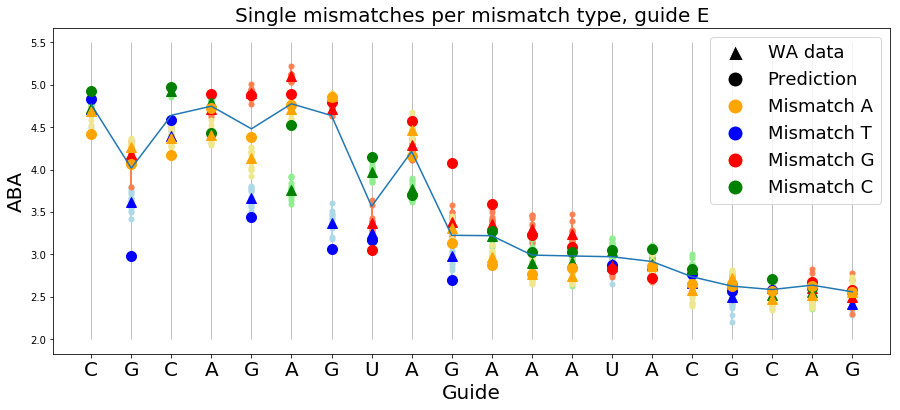

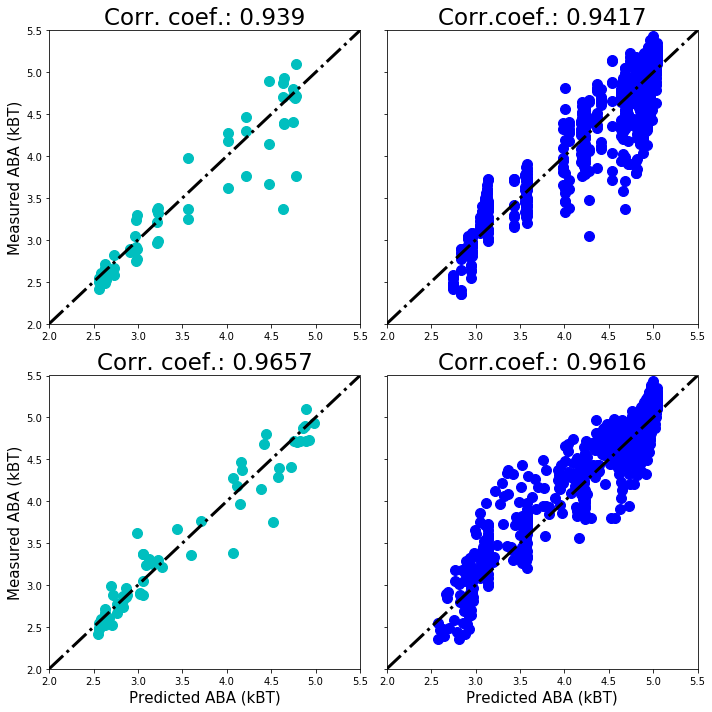

In [7]:
guide_sequenceE = 'CGCAGAGUAGAAAUACGCAG'
labelE = []
for i in range(20):
    labelE.append(guide_sequenceE[i])

plt.figure(figsize=[15,6])
conc = np.array([0.1, 0.3, 1, 3, 10, 30, 100, 300])
ref = 10. # in nanomolair
model_aba = model_id+'_aba'
model_aba_ref = model_id_ref+'_aba'

for j in range(len(xdata_smm_aba)):
    if len(xdata_smm_aba[j][2])>0:
        if xdata_smm_aba[j][0][xdata_smm_aba[j][2][0]-1]=='A':
            color = 'lightblue'
        elif xdata_smm_aba[j][0][xdata_smm_aba[j][2][0]-1]=='T':
            color = 'khaki'
        elif xdata_smm_aba[j][0][xdata_smm_aba[j][2][0]-1]=='C':
            color = 'coral'
        elif xdata_smm_aba[j][0][xdata_smm_aba[j][2][0]-1]=='G':
            color = 'lightgreen'
        
        plt.plot(xdata_smm_wa_aba[j][2][0]*np.ones(len(ydata_smm_aba[j])),ydata_smm_aba[j],color=color,marker='o',markersize=5.)

for j in range(len(xdata_smm_wa_aba)):
    if len(xdata_smm_wa_aba[j][2])>0:
        if xdata_smm_wa_aba[j][0][xdata_smm_wa_aba[j][2][0]-1]=='A':
            color = 'blue'
        elif xdata_smm_wa_aba[j][0][xdata_smm_wa_aba[j][2][0]-1]=='T':
            color = 'orange'
        elif xdata_smm_wa_aba[j][0][xdata_smm_wa_aba[j][2][0]-1]=='C':
            color = 'red'
        elif xdata_smm_wa_aba[j][0][xdata_smm_wa_aba[j][2][0]-1]=='G':
            color = 'green'
        
        aba_temp = clv.calc_ABA(parameters,conc,ref,xdata_smm_wa_aba[j],model_aba,before=before,after=after)
        plt.plot(xdata_smm_wa_aba[j][2][0],aba_temp,color=color,marker='o',markersize=10.)
        plt.plot(xdata_smm_wa_aba[j][2][0],ydata_smm_wa_aba[j][0],color=color,marker='^',markersize=10.)
        
model_pred = [4.76760251, 4.01617481, 4.6405378,  4.74780101, 4.48058282, 4.77633192,
 4.63726584, 3.56557206, 4.21371024, 3.22367888, 3.21931864, 2.99034006,
 2.97982624, 2.97058322, 2.9146604,  2.7342514,  2.62347558, 2.58356031,
 2.63534219, 2.55720793, 2.55241291]

plt.plot(range(1,21),model_pred[:-1])

plt.vlines(range(1,21),2,5.5,color='grey',linewidth=.5);
plt.xticks(range(1,21),labelE,fontsize=20);
plt.xlabel('Guide',fontsize=20)
plt.ylabel('ABA',fontsize=20)
plt.title('Single mismatches per mismatch type, guide E',fontsize=20)


legend_elements = [Line2D([0], [0], marker='^', color='w', label='WA data',
                          markerfacecolor='k', markersize=15),
                  Line2D([0], [0], marker='o', color='w', label='Prediction',
                          markerfacecolor='k', markersize=15),
                  Line2D([0], [0], marker='o', color='w', label='Mismatch A',
                          markerfacecolor='orange', markersize=15),
                  Line2D([0], [0], marker='o', color='w', label='Mismatch T',
                          markerfacecolor='blue', markersize=15),
                  Line2D([0], [0], marker='o', color='w', label='Mismatch G',
                          markerfacecolor='red', markersize=15),
                  Line2D([0], [0], marker='o', color='w', label='Mismatch C',
                          markerfacecolor='green', markersize=15)]
plt.legend(handles=legend_elements,fontsize=18)

f,ax = plt.subplots(2,2,sharey=True,figsize=[10,10])

smm_data = []
dmm_data = []
smm_fit = []
dmm_fit = []

for i in range(len(xdata_all_aba)):
    
    if len(xdata_all_aba[i][2])==1:
        aba_temp = clv.calc_ABA(param_ref,conc,ref,xdata_all_aba[i],model_aba_ref,before=True,after=False)
        for j in range(len(ydata_all_wa_aba[i])):
            smm_data.append(ydata_all_wa_aba[i][j])
            smm_fit.append(aba_temp)
    if len(xdata_all_aba[i][2])==2:
        if xdata_all_aba[i][2][0] != xdata_all_wa_aba[i][2][1] - 1: #neighbouring mismatches cannot be predicted well
            aba_temp = clv.calc_ABA(param_ref,conc,ref,xdata_all_wa_aba[i],model_aba_ref,before=True,after=False)
            for j in range(len(ydata_all_wa_aba[i])):
                dmm_data.append(ydata_all_wa_aba[i][j])
                dmm_fit.append(aba_temp)
                

ax[0][0].plot(smm_fit,smm_data,marker='o',markersize=10,color='c',linewidth=0.0)
ax[0][1].plot(dmm_fit,dmm_data,marker='o',markersize=10,color='blue',linewidth=0.0)
ax[0][0].plot([2,5.5],[2,5.5],'k-.',linewidth=3)
ax[0][0].axis([2,5.5,2,5.5])
ax[0][1].plot([2,5.5],[2,5.5],'k-.',linewidth=3)
ax[0][1].axis([2,5.5,2,5.5])
ax[0][0].set_title('Corr. coef.: ' + str(np.round(np.corrcoef([smm_data,smm_fit])[0][1],4)),fontsize=23)
ax[0][1].set_title('Corr.coef.: ' + str(np.round(np.corrcoef([dmm_data,dmm_fit])[0][1],4)), fontsize=23)
#ax[0][0].set_xlabel('Predicted ABA',fontsize=15)
ax[0][0].set_ylabel('Measured ABA (kBT)',fontsize=15)

smm_data = []
dmm_data = []
smm_fit = []
dmm_fit = []

for i in range(len(xdata_all_aba)):
    if len(xdata_all_aba[i][2])==1:
        aba_temp = clv.calc_ABA(parameters,conc,ref,xdata_all_aba[i],model_aba,before=before,after=after)
        for j in range(len(ydata_all_wa_aba[i])):
            smm_data.append(ydata_all_wa_aba[i][j])
            smm_fit.append(aba_temp)
    if len(xdata_all_aba[i][2])==2:
        if xdata_all_aba[i][2][0] != xdata_all_aba[i][2][1] - 1: #neighbouring mismatches cannot be predicted well
            aba_temp = clv.calc_ABA(parameters,conc,ref,xdata_all_aba[i],model_aba,before=before,after=after)
            #if aba_temp > 4.225 and aba_temp < 4.240:
                #print xdata_all_aba[i]
            for j in range(len(ydata_all_wa_aba[i])):
                dmm_data.append(ydata_all_wa_aba[i][j])
                dmm_fit.append(aba_temp)
                

plt1, = ax[1][0].plot(smm_fit,smm_data,marker='o',markersize=10,color='c',linewidth=0.0, label='smm')
plt2, = ax[1][1].plot(dmm_fit,dmm_data,marker='o',markersize=10,color='blue',linewidth=0.0, label='dmm')
ax[1][0].plot([2,5.5],[2,5.5],'k-.',linewidth=3)
ax[1][0].axis([2,5.5,2,5.5])
ax[1][1].plot([2,5.5],[2,5.5],'k-.',linewidth=3)
ax[1][1].axis([2,5.5,2,5.5])
ax[1][0].set_title('Corr. coef.: ' + str(np.round(np.corrcoef([smm_data,smm_fit])[0][1],4)),fontsize=23)
ax[1][1].set_title('Corr.coef.: ' + str(np.round(np.corrcoef([dmm_data,dmm_fit])[0][1],4)), fontsize=23)
ax[1][0].set_xlabel('Predicted ABA (kBT)',fontsize=15)
ax[1][1].set_xlabel('Predicted ABA (kBT)',fontsize=15)
ax[1][0].set_ylabel('Measured ABA (kBT)',fontsize=15)
#plt.legend(handles=[plt1,plt2],fontsize=17)
plt.tight_layout()
print 'Upper correlation plots are of sequence indep model'

[0, 21, -2, 2]

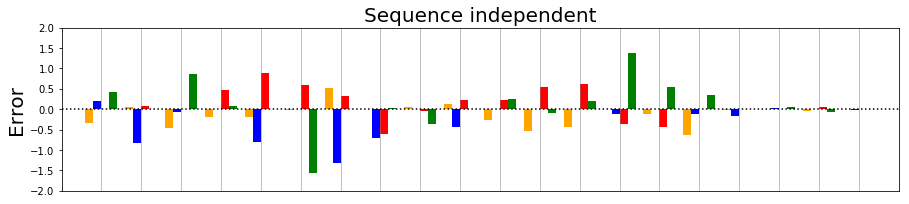

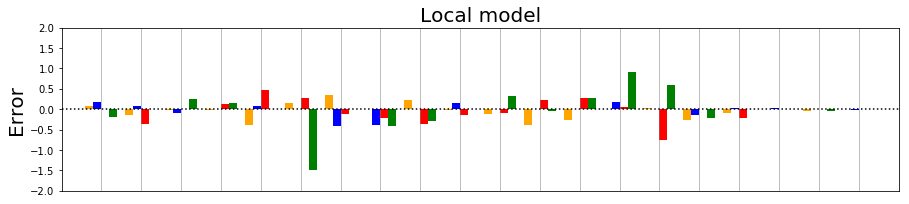

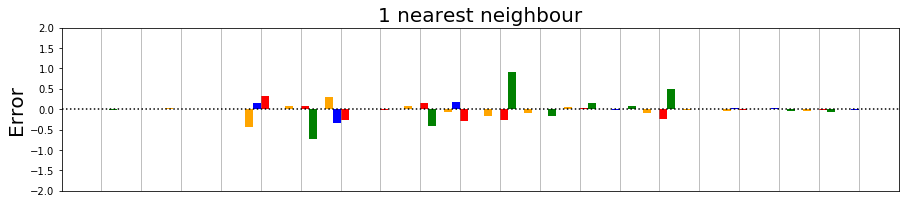

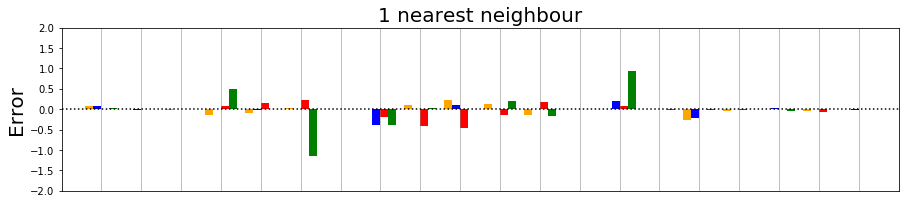

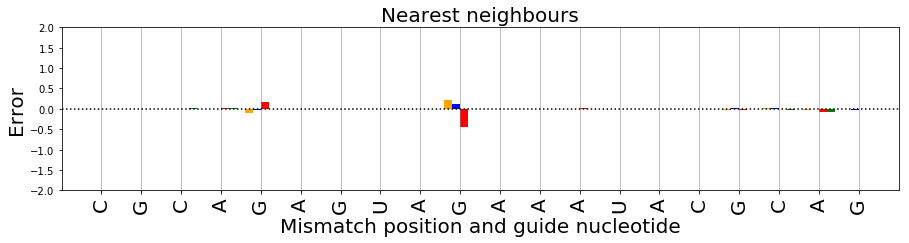

In [8]:
model_pred = [-3.23320887, -2.49715444, -3.04304113, -3.26276305, -2.90649393, -3.37527882,
                 -3.14329681, -2.18467131, -2.35215769, -1.63962913, -1.8469779,  -1.9731426,
                 -2.54474827, -2.3326522,  -2.19072379, -1.74259479, -1.03922173, -0.84372966,
                 -0.93060421, -0.83024852, -0.82914231]

plt.figure(figsize=[15,3])

guide_sequenceE = 'CGCAGAGUAGAAAUACGCAG'
labelE = []
for i in range(20):
    labelE.append(guide_sequenceE[i]) 
    
plt.figure(figsize=[15,3])
            
for j in range(len(xdata_smm_wa)):
    if len(xdata_smm_wa[j][2])>0:
        if xdata_smm_wa[j][0][xdata_smm_wa[j][2][0]-1]=='A':
            color = 'blue'
            clv_temp = np.log10(clv2.calc_clv_rate_fast(parameters_clv,model_ID_clv,xdata_smm_wa[j][2]))
            plt.bar(xdata_smm_wa[j][2][0]-0.1,(model_pred[xdata_smm_wa[j][2][0]-1]-ydata_smm_wa[j][0]),0.2,color=color)
        elif xdata_smm_wa[j][0][xdata_smm_wa[j][2][0]-1]=='T':
            color = 'orange'
            clv_temp = np.log10(clv2.calc_clv_rate_fast(parameters_clv,model_ID_clv,xdata_smm_wa[j][2]))
            plt.bar(xdata_smm_wa[j][2][0]-0.3,(model_pred[xdata_smm_wa[j][2][0]-1]-ydata_smm_wa[j][0]),0.2,color=color)
        elif xdata_smm_wa[j][0][xdata_smm_wa[j][2][0]-1]=='C':
            color = 'red'
            clv_temp = np.log10(clv2.calc_clv_rate_fast(parameters_clv,model_ID_clv,xdata_smm_wa[j][2]))
            plt.bar(xdata_smm_wa[j][2][0]+0.1,(model_pred[xdata_smm_wa[j][2][0]-1]-ydata_smm_wa[j][0]),0.2,color=color)
        elif xdata_smm_wa[j][0][xdata_smm_wa[j][2][0]-1]=='G':
            color = 'green'
            clv_temp = np.log10(clv2.calc_clv_rate_fast(parameters_clv,model_ID_clv,xdata_smm_wa[j][2]))
            plt.bar(xdata_smm_wa[j][2][0]+0.3,(model_pred[xdata_smm_wa[j][2][0]-1]-ydata_smm_wa[j][0]),0.2,color=color)

plt.vlines(range(1,21),-2,2,color='grey',linewidth=.5);
#plt.xticks(range(1,21),labelE,fontsize=20);
#plt.xlabel('Guide, target E',fontsize=20)
plt.xticks([],[])
plt.ylabel('Error',fontsize=20)
plt.title('Sequence independent',fontsize=20)
legend_elements = [Line2D([0], [0], marker='o', color='w', label='Mismatch A',
                          markerfacecolor='orange', markersize=15),
                  Line2D([0], [0], marker='o', color='w', label='Mismatch T',
                          markerfacecolor='blue', markersize=15),
                  Line2D([0], [0], marker='o', color='w', label='Mismatch G',
                          markerfacecolor='red', markersize=15),
                  Line2D([0], [0], marker='o', color='w', label='Mismatch C',
                          markerfacecolor='green', markersize=15)]
#plt.legend(handles=legend_elements,fontsize=18)
plt.plot([0,21],[0,0],'k:')
plt.axis([0,21,-2,2])









plt.figure(figsize=[15,3])
chi_squared = []
energies = []
simset = []
final_par = []
ei = False
before = True
after = False
direct = False

file = '../../fits_Stijn/22_8_2019/fit_22_8_2019_sim_'
model_id = 'seq_dep_finetuning_direct_pairs'; parnum = '12'; direct = True
#model_id = 'seq_dep_finetuning_nearest_neighbour'; parnum = '33'
#model_id = 'seq_dep_finetuning_direct_pairs_constant_ei'; parnum = '12'; direct = True
#model_id = 'seq_dep_finetuning_nearest_neighbour_constant_ei'; parnum = '33'
#model_id = 'seq_dep_finetuning_direct_pairs_free_ei'; parnum = '32'; ei = True; direct =True
#model_id = 'seq_dep_finetuning_nearest_neighbour_free_ei'; parnum= '53'; ei = True
#model_id = 'seq_dep_finetuning_nearest_neighbour_after'; parnum = '30';before = False; after = True
#model_id = 'seq_dep_finetuning_nearest_neighbour_both'; parnum = '45';before = True; after = True

if ei:
    epsilon_i = []

#---------- collect simulations ---------------
for sim in range(1,6):
    sa = pd.read_csv(file +str(sim)+'.txt', delimiter='\t', index_col=False)
    filename = file +str(sim) +'.txt'   
    chi_squared.append(sa.Potential.iloc[np.argmin(sa.Potential)])
    simset.append(filename)
    final_par_temp = sa.loc[np.argmin(sa.Potential),'Parameter 1':'Parameter '+parnum]
    final_par_temp = final_par_temp.values
    #final_par_temp[16] += 1.3
    
    epsilon_si,_,epsilon_i_sd = model.unpack_parameters(final_par_temp,model_id,20)
    
    if ei:
        epsilon_i.append(epsilon_si[-20:])

    energies.append(epsilon_i_sd)
    final_par.append(final_par_temp)
    
best_fit = simset[np.argmin(chi_squared)]

chi_squared = np.array(chi_squared)
indices_low_chi = np.where(chi_squared<800000)
final_par_low_chi = np.array(final_par)[indices_low_chi[0]]
energies_low_chi = np.array(energies)[indices_low_chi[0]]
low_chi = chi_squared[indices_low_chi[0]]
parameters = final_par[np.argmin(chi_squared)]

    
for j in range(len(xdata_smm_wa)):
    if len(xdata_smm_wa[j][2])>0:
        if xdata_smm_wa[j][0][xdata_smm_wa[j][2][0]-1]=='A':
            color = 'blue'
            clv_temp = np.log10(clv.calc_clv_rate_fast(parameters,model_id,xdata_smm_wa[j],before=before,after=after))
            plt.bar(xdata_smm_wa[j][2][0]-0.1,(clv_temp-ydata_smm_wa[j][0]),0.2,color=color)
        elif xdata_smm_wa[j][0][xdata_smm_wa[j][2][0]-1]=='T':
            color = 'orange'
            clv_temp = np.log10(clv.calc_clv_rate_fast(parameters,model_id,xdata_smm_wa[j],before=before,after=after))
            plt.bar(xdata_smm_wa[j][2][0]-0.3,(clv_temp-ydata_smm_wa[j][0]),0.2,color=color)
        elif xdata_smm_wa[j][0][xdata_smm_wa[j][2][0]-1]=='C':
            color = 'red'
            clv_temp = np.log10(clv.calc_clv_rate_fast(parameters,model_id,xdata_smm_wa[j],before=before,after=after))
            plt.bar(xdata_smm_wa[j][2][0]+0.1,(clv_temp-ydata_smm_wa[j][0]),0.2,color=color)
        elif xdata_smm_wa[j][0][xdata_smm_wa[j][2][0]-1]=='G':
            color = 'green'
            clv_temp = np.log10(clv.calc_clv_rate_fast(parameters,model_id,xdata_smm_wa[j],before=before,after=after))
            plt.bar(xdata_smm_wa[j][2][0]+0.3,(clv_temp-ydata_smm_wa[j][0]),0.2,color=color)
            
plt.vlines(range(1,21),-2,2,color='grey',linewidth=.5);
#plt.xticks(range(1,21),labelE,fontsize=20);
#plt.xlabel('Guide, target E',fontsize=20)
plt.xticks([],[])
plt.ylabel('Error',fontsize=20)
plt.title('Local model',fontsize=20)
legend_elements = [Line2D([0], [0], marker='o', color='w', label='Mismatch A',
                          markerfacecolor='orange', markersize=15),
                  Line2D([0], [0], marker='o', color='w', label='Mismatch T',
                          markerfacecolor='blue', markersize=15),
                  Line2D([0], [0], marker='o', color='w', label='Mismatch G',
                          markerfacecolor='red', markersize=15),
                  Line2D([0], [0], marker='o', color='w', label='Mismatch C',
                          markerfacecolor='green', markersize=15)]
#plt.legend(handles=legend_elements,fontsize=18)
plt.plot([0,21],[0,0],'k:')
plt.axis([0,21,-2,2])










plt.figure(figsize=[15,3])
chi_squared = []
energies = []
simset = []
final_par = []
ei = False
before = True
after = False
direct = False

file = '../../fits_Stijn/22_8_2019/fit_22_8_2019_sim_'
#model_id = 'seq_dep_finetuning_direct_pairs'; parnum = '12'; direct = True
model_id = 'seq_dep_finetuning_nearest_neighbour'; parnum = '33'
#model_id = 'seq_dep_finetuning_direct_pairs_constant_ei'; parnum = '12'; direct = True
#model_id = 'seq_dep_finetuning_nearest_neighbour_constant_ei'; parnum = '33'
#model_id = 'seq_dep_finetuning_direct_pairs_free_ei'; parnum = '32'; ei = True; direct =True
#model_id = 'seq_dep_finetuning_nearest_neighbour_free_ei'; parnum= '53'; ei = True
#model_id = 'seq_dep_finetuning_nearest_neighbour_after'; parnum = '30';before = False; after = True
#model_id = 'seq_dep_finetuning_nearest_neighbour_both'; parnum = '45';before = True; after = True

if ei:
    epsilon_i = []

#---------- collect simulations ---------------
for sim in range(6,11):
    sa = pd.read_csv(file +str(sim)+'.txt', delimiter='\t', index_col=False)
    filename = file +str(sim) +'.txt'   
    chi_squared.append(sa.Potential.iloc[np.argmin(sa.Potential)])
    simset.append(filename)
    final_par_temp = sa.loc[np.argmin(sa.Potential),'Parameter 1':'Parameter '+parnum]
    final_par_temp = final_par_temp.values
    #final_par_temp[16] += 1.3
    
    epsilon_si,_,epsilon_i_sd = model.unpack_parameters(final_par_temp,model_id,20)
    
    if ei:
        epsilon_i.append(epsilon_si[-20:])

    energies.append(epsilon_i_sd)
    final_par.append(final_par_temp)
    
best_fit = simset[np.argmin(chi_squared)]

chi_squared = np.array(chi_squared)
indices_low_chi = np.where(chi_squared<800000)
final_par_low_chi = np.array(final_par)[indices_low_chi[0]]
energies_low_chi = np.array(energies)[indices_low_chi[0]]
low_chi = chi_squared[indices_low_chi[0]]
parameters = final_par[np.argmin(chi_squared)]

    
for j in range(len(xdata_smm_wa)):
    if len(xdata_smm_wa[j][2])>0:
        if xdata_smm_wa[j][0][xdata_smm_wa[j][2][0]-1]=='A':
            color = 'blue'
            clv_temp = np.log10(clv.calc_clv_rate_fast(parameters,model_id,xdata_smm_wa[j],before=before,after=after))
            plt.bar(xdata_smm_wa[j][2][0]-0.1,(clv_temp-ydata_smm_wa[j][0]),0.2,color=color)
        elif xdata_smm_wa[j][0][xdata_smm_wa[j][2][0]-1]=='T':
            color = 'orange'
            clv_temp = np.log10(clv.calc_clv_rate_fast(parameters,model_id,xdata_smm_wa[j],before=before,after=after))
            plt.bar(xdata_smm_wa[j][2][0]-0.3,(clv_temp-ydata_smm_wa[j][0]),0.2,color=color)
        elif xdata_smm_wa[j][0][xdata_smm_wa[j][2][0]-1]=='C':
            color = 'red'
            clv_temp = np.log10(clv.calc_clv_rate_fast(parameters,model_id,xdata_smm_wa[j],before=before,after=after))
            plt.bar(xdata_smm_wa[j][2][0]+0.1,(clv_temp-ydata_smm_wa[j][0]),0.2,color=color)
        elif xdata_smm_wa[j][0][xdata_smm_wa[j][2][0]-1]=='G':
            color = 'green'
            clv_temp = np.log10(clv.calc_clv_rate_fast(parameters,model_id,xdata_smm_wa[j],before=before,after=after))
            plt.bar(xdata_smm_wa[j][2][0]+0.3,(clv_temp-ydata_smm_wa[j][0]),0.2,color=color)
            
plt.vlines(range(1,21),-2,2,color='grey',linewidth=.5);
#plt.xticks(range(1,21),labelE,fontsize=20);
#plt.xlabel('Guide, target E',fontsize=20)
plt.xticks([],[])
plt.ylabel('Error',fontsize=20)
plt.title('1 nearest neighbour',fontsize=20)
legend_elements = [Line2D([0], [0], marker='o', color='w', label='Mismatch A',
                          markerfacecolor='orange', markersize=15),
                  Line2D([0], [0], marker='o', color='w', label='Mismatch T',
                          markerfacecolor='blue', markersize=15),
                  Line2D([0], [0], marker='o', color='w', label='Mismatch G',
                          markerfacecolor='red', markersize=15),
                  Line2D([0], [0], marker='o', color='w', label='Mismatch C',
                          markerfacecolor='green', markersize=15)]
#plt.legend(handles=legend_elements,fontsize=18)
plt.plot([0,21],[0,0],'k:')
plt.axis([0,21,-2,2])








plt.figure(figsize=[15,3])
chi_squared = []
energies = []
simset = []
final_par = []
ei = False
before = True
after = False
direct = False

file = '../../fits_Stijn/26_8_2019/fit_26_8_2019_sim_'
#model_id = 'seq_dep_finetuning_direct_pairs'; parnum = '12'; direct = True
#model_id = 'seq_dep_finetuning_nearest_neighbour'; parnum = '33'
#model_id = 'seq_dep_finetuning_direct_pairs_constant_ei'; parnum = '12'; direct = True
#model_id = 'seq_dep_finetuning_nearest_neighbour_constant_ei'; parnum = '33'
#model_id = 'seq_dep_finetuning_direct_pairs_free_ei'; parnum = '32'; ei = True; direct =True
#model_id = 'seq_dep_finetuning_nearest_neighbour_free_ei'; parnum= '53'; ei = True
model_id = 'seq_dep_finetuning_nearest_neighbour_after'; parnum = '30';before = False; after = True
#model_id = 'seq_dep_finetuning_nearest_neighbour_both'; parnum = '45';before = True; after = True

if ei:
    epsilon_i = []

#---------- collect simulations ---------------
for sim in range(1,6):
    sa = pd.read_csv(file +str(sim)+'.txt', delimiter='\t', index_col=False)
    filename = file +str(sim) +'.txt'   
    chi_squared.append(sa.Potential.iloc[np.argmin(sa.Potential)])
    simset.append(filename)
    final_par_temp = sa.loc[np.argmin(sa.Potential),'Parameter 1':'Parameter '+parnum]
    final_par_temp = final_par_temp.values
    #final_par_temp[16] += 1.3
    
    epsilon_si,_,epsilon_i_sd = model.unpack_parameters(final_par_temp,model_id,20)
    
    if ei:
        epsilon_i.append(epsilon_si[-20:])

    energies.append(epsilon_i_sd)
    final_par.append(final_par_temp)
    
best_fit = simset[np.argmin(chi_squared)]

chi_squared = np.array(chi_squared)
indices_low_chi = np.where(chi_squared<800000)
final_par_low_chi = np.array(final_par)[indices_low_chi[0]]
energies_low_chi = np.array(energies)[indices_low_chi[0]]
low_chi = chi_squared[indices_low_chi[0]]
parameters = final_par[np.argmin(chi_squared)]

    
for j in range(len(xdata_smm_wa)):
    if len(xdata_smm_wa[j][2])>0:
        if xdata_smm_wa[j][0][xdata_smm_wa[j][2][0]-1]=='A':
            color = 'blue'
            clv_temp = np.log10(clv.calc_clv_rate_fast(parameters,model_id,xdata_smm_wa[j],before=before,after=after))
            plt.bar(xdata_smm_wa[j][2][0]-0.1,(clv_temp-ydata_smm_wa[j][0]),0.2,color=color)
        elif xdata_smm_wa[j][0][xdata_smm_wa[j][2][0]-1]=='T':
            color = 'orange'
            clv_temp = np.log10(clv.calc_clv_rate_fast(parameters,model_id,xdata_smm_wa[j],before=before,after=after))
            plt.bar(xdata_smm_wa[j][2][0]-0.3,(clv_temp-ydata_smm_wa[j][0]),0.2,color=color)
        elif xdata_smm_wa[j][0][xdata_smm_wa[j][2][0]-1]=='C':
            color = 'red'
            clv_temp = np.log10(clv.calc_clv_rate_fast(parameters,model_id,xdata_smm_wa[j],before=before,after=after))
            plt.bar(xdata_smm_wa[j][2][0]+0.1,(clv_temp-ydata_smm_wa[j][0]),0.2,color=color)
        elif xdata_smm_wa[j][0][xdata_smm_wa[j][2][0]-1]=='G':
            color = 'green'
            clv_temp = np.log10(clv.calc_clv_rate_fast(parameters,model_id,xdata_smm_wa[j],before=before,after=after))
            plt.bar(xdata_smm_wa[j][2][0]+0.3,(clv_temp-ydata_smm_wa[j][0]),0.2,color=color)
            
plt.vlines(range(1,21),-2,2,color='grey',linewidth=.5);
#plt.xticks(range(1,21),labelE,fontsize=20);
#plt.xlabel('Guide, target E',fontsize=20)
plt.xticks([],[])
plt.ylabel('Error',fontsize=20)
plt.title('1 nearest neighbour',fontsize=20)
legend_elements = [Line2D([0], [0], marker='o', color='w', label='Mismatch A',
                          markerfacecolor='orange', markersize=15),
                  Line2D([0], [0], marker='o', color='w', label='Mismatch T',
                          markerfacecolor='blue', markersize=15),
                  Line2D([0], [0], marker='o', color='w', label='Mismatch G',
                          markerfacecolor='red', markersize=15),
                  Line2D([0], [0], marker='o', color='w', label='Mismatch C',
                          markerfacecolor='green', markersize=15)]
#plt.legend(handles=legend_elements,fontsize=18)
plt.plot([0,21],[0,0],'k:')
plt.axis([0,21,-2,2])









plt.figure(figsize=[15,3])
chi_squared = []
energies = []
simset = []
final_par = []
ei = False
before = True
after = False
direct = False

file = '../../fits_Stijn/26_8_2019/fit_26_8_2019_sim_'
#model_id = 'seq_dep_finetuning_direct_pairs'; parnum = '12'; direct = True
#model_id = 'seq_dep_finetuning_nearest_neighbour'; parnum = '33'
#model_id = 'seq_dep_finetuning_direct_pairs_constant_ei'; parnum = '12'; direct = True
#model_id = 'seq_dep_finetuning_nearest_neighbour_constant_ei'; parnum = '33'
#model_id = 'seq_dep_finetuning_direct_pairs_free_ei'; parnum = '32'; ei = True; direct =True
#model_id = 'seq_dep_finetuning_nearest_neighbour_free_ei'; parnum= '53'; ei = True
#model_id = 'seq_dep_finetuning_nearest_neighbour_after'; parnum = '30';before = False; after = True
model_id = 'seq_dep_finetuning_nearest_neighbour_both'; parnum = '45';before = True; after = True

if ei:
    epsilon_i = []

#---------- collect simulations ---------------
for sim in range(6,11):
    sa = pd.read_csv(file +str(sim)+'.txt', delimiter='\t', index_col=False)
    filename = file +str(sim) +'.txt'   
    chi_squared.append(sa.Potential.iloc[np.argmin(sa.Potential)])
    simset.append(filename)
    final_par_temp = sa.loc[np.argmin(sa.Potential),'Parameter 1':'Parameter '+parnum]
    final_par_temp = final_par_temp.values
    #final_par_temp[16] += 1.3
    
    epsilon_si,_,epsilon_i_sd = model.unpack_parameters(final_par_temp,model_id,20)
    
    if ei:
        epsilon_i.append(epsilon_si[-20:])

    energies.append(epsilon_i_sd)
    final_par.append(final_par_temp)
    
best_fit = simset[np.argmin(chi_squared)]

chi_squared = np.array(chi_squared)
indices_low_chi = np.where(chi_squared<800000)
final_par_low_chi = np.array(final_par)[indices_low_chi[0]]
energies_low_chi = np.array(energies)[indices_low_chi[0]]
low_chi = chi_squared[indices_low_chi[0]]
parameters = final_par[np.argmin(chi_squared)]

    
for j in range(len(xdata_smm_wa)):
    if len(xdata_smm_wa[j][2])>0:
        if xdata_smm_wa[j][0][xdata_smm_wa[j][2][0]-1]=='A':
            color = 'blue'
            clv_temp = np.log10(clv.calc_clv_rate_fast(parameters,model_id,xdata_smm_wa[j],before=before,after=after))
            plt.bar(xdata_smm_wa[j][2][0]-0.1,(clv_temp-ydata_smm_wa[j][0]),0.2,color=color)
        elif xdata_smm_wa[j][0][xdata_smm_wa[j][2][0]-1]=='T':
            color = 'orange'
            clv_temp = np.log10(clv.calc_clv_rate_fast(parameters,model_id,xdata_smm_wa[j],before=before,after=after))
            plt.bar(xdata_smm_wa[j][2][0]-0.3,(clv_temp-ydata_smm_wa[j][0]),0.2,color=color)
        elif xdata_smm_wa[j][0][xdata_smm_wa[j][2][0]-1]=='C':
            color = 'red'
            clv_temp = np.log10(clv.calc_clv_rate_fast(parameters,model_id,xdata_smm_wa[j],before=before,after=after))
            plt.bar(xdata_smm_wa[j][2][0]+0.1,(clv_temp-ydata_smm_wa[j][0]),0.2,color=color)
        elif xdata_smm_wa[j][0][xdata_smm_wa[j][2][0]-1]=='G':
            color = 'green'
            clv_temp = np.log10(clv.calc_clv_rate_fast(parameters,model_id,xdata_smm_wa[j],before=before,after=after))
            plt.bar(xdata_smm_wa[j][2][0]+0.3,(clv_temp-ydata_smm_wa[j][0]),0.2,color=color)
            
plt.vlines(range(1,21),-2,2,color='grey',linewidth=.5);
plt.xticks(range(1,21),labelE,fontsize=20,rotation='vertical');
plt.xlabel('Mismatch position and guide nucleotide', fontsize=20)
#plt.xticks([],[])
plt.ylabel('Error',fontsize=20)
plt.title('Nearest neighbours',fontsize=20)

legend_elements = [Line2D([0], [0], marker='o', color='w', label='Mismatch A',
                          markerfacecolor='orange', markersize=15),
                  Line2D([0], [0], marker='o', color='w', label='Mismatch T',
                          markerfacecolor='blue', markersize=15),
                  Line2D([0], [0], marker='o', color='w', label='Mismatch G',
                          markerfacecolor='red', markersize=15),
                  Line2D([0], [0], marker='o', color='w', label='Mismatch C',
                          markerfacecolor='green', markersize=15)]
#plt.legend(handles=legend_elements,fontsize=18)
plt.plot([0,21],[0,0],'k:')
plt.axis([0,21,-2,2])